# LAPD crimes database: 2010-present

### Import data tools

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
import geojson
import json
import jenkspy
import numpy as np
from earthpy import clip as cl
from altair import datum
import altair as alt
alt.renderers.enable('notebook')
import altair_latimes as lat
alt.themes.register('latimes', lat.theme)
alt.themes.enable('latimes')
pd.options.display.max_columns = 50
pd.options.display.max_rows = 1000

### Read crimes CSV downloaded from LA City data portal

In [2]:
#https://data.lacity.org/A-Safe-City/Crime-Data-from-2010-to-Present/63jg-8b9z
src = pd.read_csv('/Users/mhustiles/data/data/LA/Crime_Data_from_2010_to_Present.csv')

In [3]:
crimes = src

In [4]:
crimes.columns = crimes.columns.str.strip().str.lower()\
.str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

### These data are super messy...

In [5]:
crimes.rename(columns = { 
'dr_no':'record_id',
'date_rptd':'date_reported',
'date_occ':'date_occurred',
'time_occ':'time_occurred',
'area':'division',
'area_name':'division_name',
'rpt_dist_no':'reporting_district',
'part_1-2':'part_type',
'crm_cd':'crime_code',
'crm_cd_desc':'crime_code_description',
'mocodes':'modus_operandi_code',
'vict_age':'victim_age',
'vict_sex':'victim_sex',
'vict_descent':'victim_descent',
'premis_cd':'premises_code',
'premis_desc':'premises_description',
'weapon_used_cd':'weapon_code',
'weapon_desc':'weapon_description',
'status':'status_code',
'status_desc':'status_code_description',
'crm_cd_1':'crm_cd_1',
'crm_cd_2':'crm_cd_2',
'crm_cd_3':'crm_cd_3',
'crm_cd_4':'crm_cd_4',
'location':'address',
'cross_street':'cross_street',
'lat':'latitude',
'lon':'longitide',
 }, inplace = True)

### ... contunued

In [6]:
crimes['date_reported'] = crimes['date_reported'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = crimes['date_occurred'].str.replace(' 12:00:00 AM','')
crimes['date_occurred'] = pd.to_datetime(crimes['date_occurred'], format='%m/%d/%Y')
crimes['year'] = crimes['date_occurred'].dt.year
crimes['quarter'] = crimes['date_occurred'].dt.quarter
crimes['day'] = crimes['date_occurred'].dt.day
crimes['month'] = crimes['date_occurred'].dt.month
crimes['weekday'] = crimes['date_occurred'].dt.weekday_name

In [7]:
crimes[[ 'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month', ]] = crimes[[
    'record_id', 
    'time_occurred', 
    'division', 
    'reporting_district', 
    'part_type',
    'crm_cd_1',
    'crm_cd_2',
    'crm_cd_3',
    'crm_cd_4',
    'crime_code', 
    'premises_code', 
    'weapon_code',
    'year',
    'quarter',
    'day',
    'month',]].astype(str)

In [8]:
crimes.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday
0,1307355,02/20/2010,2010-02-20,1350,13,Newton,1385,2,900,VIOLATION OF COURT ORDER,0913 1814 2000,48,M,H,501.0,SINGLE FAMILY DWELLING,nan,NaN,AA,Adult Arrest,900.0,nan,nan,nan,300 E GAGE AV,NaN,33.9825,-118.2695,2010,1,20,2,Saturday
1,11401303,09/13/2010,2010-09-12,45,14,Pacific,1485,2,740,"VANDALISM - FELONY ($400 & OVER, ALL CHURCH VA...",0329,0,M,W,101.0,STREET,nan,NaN,IC,Invest Cont,740.0,nan,nan,nan,SEPULVEDA BL,MANCHESTER AV,33.9599,-118.3962,2010,3,12,9,Sunday
2,70309629,08/09/2010,2010-08-09,1515,13,Newton,1324,2,946,OTHER MISCELLANEOUS CRIME,0344,0,M,H,103.0,ALLEY,nan,NaN,IC,Invest Cont,946.0,nan,nan,nan,1300 E 21ST ST,NaN,34.0224,-118.2524,2010,3,9,8,Monday
3,90631215,01/05/2010,2010-01-05,150,6,Hollywood,646,2,900,VIOLATION OF COURT ORDER,1100 0400 1402,47,F,W,101.0,STREET,102.0,HAND GUN,IC,Invest Cont,900.0,998.0,nan,nan,CAHUENGA BL,HOLLYWOOD BL,34.1016,-118.3295,2010,1,5,1,Tuesday
4,100100501,01/03/2010,2010-01-02,2100,1,Central,176,1,122,"RAPE, ATTEMPTED",0400,47,F,H,103.0,ALLEY,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",IC,Invest Cont,122.0,nan,nan,nan,8TH ST,SAN PEDRO ST,34.0387,-118.2488,2010,1,2,1,Saturday


In [9]:
crimes['time_occurred'] = crimes['time_occurred'].str.replace('.0','', regex=False)
crimes['time_occurred'] = crimes['time_occurred'].str.zfill(4)
crimes['hour'] = crimes['time_occurred'].str[:2]
crimes['minute'] = crimes['time_occurred'].str[2:]
crimes = crimes[crimes['hour'] != '0n']
crimes = crimes[crimes['hour'] != '24']

---

In [10]:
mocrimes = crimes.dropna(subset=['modus_operandi_code'])
homicides = crimes[crimes['crime_code_description'].str.contains('CRIMINAL HOMICIDE', na=False)]

In [37]:
mocodes = pd.read_csv('mo_codes.csv')

In [39]:
# MO Code 1218 is to be used when a victim is homeless
# MO Code 2004 is to be used when a suspect is homeless
mocodes_homeless = mocodes[mocodes['mo_code_description'].str.lower().str.contains('homeless')]
mocodes_homeless.head()

,mo_code,mo_code_description
361,1218,Victim was Homeless/Transient
521,2004,Suspect is homeless/transient


In [50]:
homeless_dates = ['2015','2016', '2017', '2018', '2019']

In [51]:
homeless_victims = crimes[(crimes['modus_operandi_code'].str.contains('1218', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_suspects = crimes[(crimes['modus_operandi_code'].str.contains('2004', na=False)) & (crimes['year'].isin(homeless_dates))]
homeless_homicides = homeless_victims[(homeless_victims['crime_code_description']\
                    .str.contains('CRIMINAL HOMICIDE', na=False))\
                    & (homeless_victims['year'].isin(homeless_dates))]

In [52]:
len(homeless_victims)

16168

In [53]:
len(homeless_suspects)

33843

In [54]:
homeless_homicides_years = homeless_homicides.groupby(['year']).agg('size').reset_index(name='total')

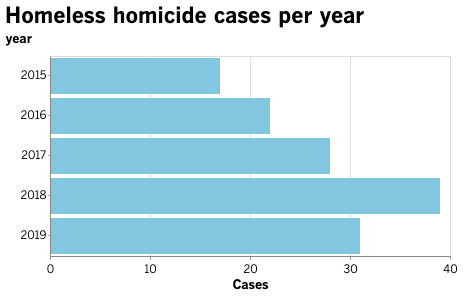

In [55]:
alt.Chart(homeless_homicides_years).mark_bar().encode(
    y=alt.Y('year:N', axis=alt.Axis(format='', tickCount=5)),
    x=alt.X("total:Q", title="Cases", axis=alt.Axis(format='', tickCount=5)),
).properties(height=200, width=400, columns=3, title='Homeless homicide cases per year')

In [56]:
homeless_victims.groupby(['crime_code_description']).agg('size').sort_values(ascending=False).head(10)

crime_code_description
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT    3993
BATTERY - SIMPLE ASSAULT                          2916
ROBBERY                                           1810
THEFT PLAIN - PETTY ($950 & UNDER)                1664
INTIMATE PARTNER - SIMPLE ASSAULT                 1632
INTIMATE PARTNER - AGGRAVATED ASSAULT              666
RAPE, FORCIBLE                                     450
BRANDISH WEAPON                                    415
CRIMINAL THREATS - NO WEAPON DISPLAYED             324
ATTEMPTED ROBBERY                                  249
dtype: int64

In [57]:
homeless_suspects.groupby(['crime_code_description']).agg('size').sort_values(ascending=False).head(10)

crime_code_description
ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT             4745
BATTERY - SIMPLE ASSAULT                                   4592
TRESPASSING                                                2823
ROBBERY                                                    2713
SHOPLIFTING - PETTY THEFT ($950 & UNDER)                   2520
INTIMATE PARTNER - SIMPLE ASSAULT                          1978
VANDALISM - FELONY ($400 & OVER, ALL CHURCH VANDALISMS)    1476
THEFT PLAIN - PETTY ($950 & UNDER)                         1226
CRIMINAL THREATS - NO WEAPON DISPLAYED                     1138
BURGLARY                                                   1127
dtype: int64

In [58]:
homicides.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,hour,minute
113,100100811,04/16/2010,2010-04-16,0510,1,Central,154,1,110,CRIMINAL HOMICIDE,1100,41,M,B,102.0,SIDEWALK,106.0,UNKNOWN FIREARM,AA,Adult Arrest,110.0,nan,nan,nan,500 S LOS ANGELES ST,NaN,34.0461,-118.2476,2010,2,16,4,Friday,05,10
404,100101605,11/15/2010,2010-11-14,1245,1,Central,157,1,110,CRIMINAL HOMICIDE,0416 1218,48,M,O,102.0,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,110.0,nan,nan,nan,500 CROCKER ST,NaN,34.0435,-118.2427,2010,4,14,11,Sunday,12,45
524,100104269,01/05/2010,2010-01-05,1030,1,Central,138,1,110,CRIMINAL HOMICIDE,0411,74,F,A,203.0,OTHER BUSINESS,500.0,UNKNOWN WEAPON/OTHER WEAPON,AA,Adult Arrest,110.0,nan,nan,nan,400 E 4TH ST,NaN,34.0458,-118.2430,2010,1,5,1,Tuesday,10,30
2488,100110330,05/05/2010,2010-01-15,1200,1,Central,134,1,110,CRIMINAL HOMICIDE,0400 0411,65,M,W,102.0,SIDEWALK,207.0,OTHER KNIFE,IC,Invest Cont,110.0,nan,nan,nan,300 S HILL ST,NaN,34.0517,-118.2491,2010,1,15,1,Friday,12,00
3459,100112967,06/24/2010,2010-06-24,2000,1,Central,166,1,110,CRIMINAL HOMICIDE,0416 0429 1218,62,M,B,102.0,SIDEWALK,400.0,"STRONG-ARM (HANDS, FIST, FEET OR BODILY FORCE)",AA,Adult Arrest,110.0,nan,nan,nan,7TH ST,SAN JULIAN,34.0407,-118.2468,2010,2,24,6,Thursday,20,00


In [59]:
homeless_victims.head()

,record_id,date_reported,date_occurred,time_occurred,division,division_name,reporting_district,part_type,crime_code,crime_code_description,modus_operandi_code,victim_age,victim_sex,victim_descent,premises_code,premises_description,weapon_code,weapon_description,status_code,status_code_description,crm_cd_1,crm_cd_2,crm_cd_3,crm_cd_4,address,cross_street,latitude,longitide,year,quarter,day,month,weekday,hour,minute
998005,150122470,10/07/2015,2015-10-07,0430,1,Central,147,1,230,"ASSAULT WITH DEADLY WEAPON, AGGRAVATED ASSAULT",0416 1218,34,F,H,102.0,SIDEWALK,311.0,HAMMER,IC,Invest Cont,230.0,nan,nan,nan,WINSTON,SAN PEDRO,34.0450,-118.2435,2015,4,7,10,Wednesday,04,30
998115,150610223,04/06/2015,2015-04-06,1100,6,Hollywood,666,1,440,THEFT PLAIN - PETTY ($950 & UNDER),0344 1218 1268,24,M,B,717.0,HEALTH SPA/GYM,nan,NaN,IC,Invest Cont,440.0,nan,nan,nan,6400 W SUNSET BL,NaN,34.0980,-118.3287,2015,2,6,4,Monday,11,00
998222,151107210,03/08/2015,2015-03-08,0025,11,Northeast,1115,1,341,"THEFT-GRAND ($950.01 & OVER)EXCPT,GUNS,FOWL,LI...",0344 1202 1218,76,M,W,102.0,SIDEWALK,nan,NaN,IC,Invest Cont,341.0,nan,nan,nan,2300 COLORADO BL,NaN,34.1395,-118.2163,2015,1,8,3,Sunday,00,25
998231,151614778,10/15/2015,2015-10-15,1305,16,Foothill,1633,1,442,SHOPLIFTING - PETTY THEFT ($950 & UNDER),1402 1218 0104,50,F,B,218.0,BEAUTY/BARBER SHOP,nan,NaN,AA,Adult Arrest,442.0,nan,nan,nan,11900 FOOTHILL BL,NaN,34.2749,-118.3955,2015,4,15,10,Thursday,13,05
998261,150114124,06/04/2015,2015-06-04,2100,1,Central,123,1,350,"THEFT, PERSON",1218 2004 0344 0346,53,M,H,116.0,OTHER/OUTSIDE,nan,NaN,IC,Invest Cont,350.0,nan,nan,nan,200 W TEMPLE ST,NaN,34.0549,-118.2426,2015,2,4,6,Thursday,21,00
